In [1]:
!git clone https://github.com/Arman-Rayan-Sharif/arman-text-emotion.git

fatal: destination path 'arman-text-emotion' already exists and is not an empty directory.


In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("Persian Text Emotion Classification - Enhanced Version")
print("=" * 60)

Persian Text Emotion Classification - Enhanced Version


# ----------------------------
# Load and Inspect Datasets
# ----------------------------

In [3]:
train_path = "/content/arman-text-emotion/dataset/train.tsv"
test_path = "/content/arman-text-emotion/dataset/test.tsv"

train_df = pd.read_csv(train_path, sep='\t', names=['text', 'label'])
test_df = pd.read_csv(test_path, sep='\t', names=['text', 'label'])

print("Dataset Information:")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Training columns: {train_df.columns.tolist()}")

Dataset Information:
Training samples: 6125
Test samples: 1151
Training columns: ['text', 'label']


# ----------------------------
# Data Quality Check
# ----------------------------

In [4]:
print("\n Data Quality Check:")

# Check for missing values
print("Missing values in training set:")
print(train_df.isnull().sum())

print("\nMissing values in test set:")
print(test_df.isnull().sum())

# Check for duplicates
train_duplicates = train_df.duplicated().sum()
test_duplicates = test_df.duplicated().sum()
print(f"\nDuplicate rows - Train: {train_duplicates}, Test: {test_duplicates}")

# Handle missing values if any
train_df = train_df.dropna()
test_df = test_df.dropna()


 Data Quality Check:
Missing values in training set:
text     0
label    0
dtype: int64

Missing values in test set:
text     0
label    0
dtype: int64

Duplicate rows - Train: 37, Test: 0


# ----------------------------
# Exploratory Data Analysis
# ----------------------------


Label Distribution Analysis:
Training set labels:
  OTHER: 1681 (27.4%)
  ANGRY: 923 (15.1%)
  SAD: 896 (14.6%)
  FEAR: 757 (12.4%)
  SURPRISE: 739 (12.1%)
  HAPPY: 618 (10.1%)
  HATE: 511 (8.3%)

Test set labels:
  HAPPY: 275 (23.9%)
  SAD: 262 (22.8%)
  OTHER: 193 (16.8%)
  ANGRY: 154 (13.4%)
  SURPRISE: 145 (12.6%)
  HATE: 65 (5.6%)
  FEAR: 57 (5.0%)


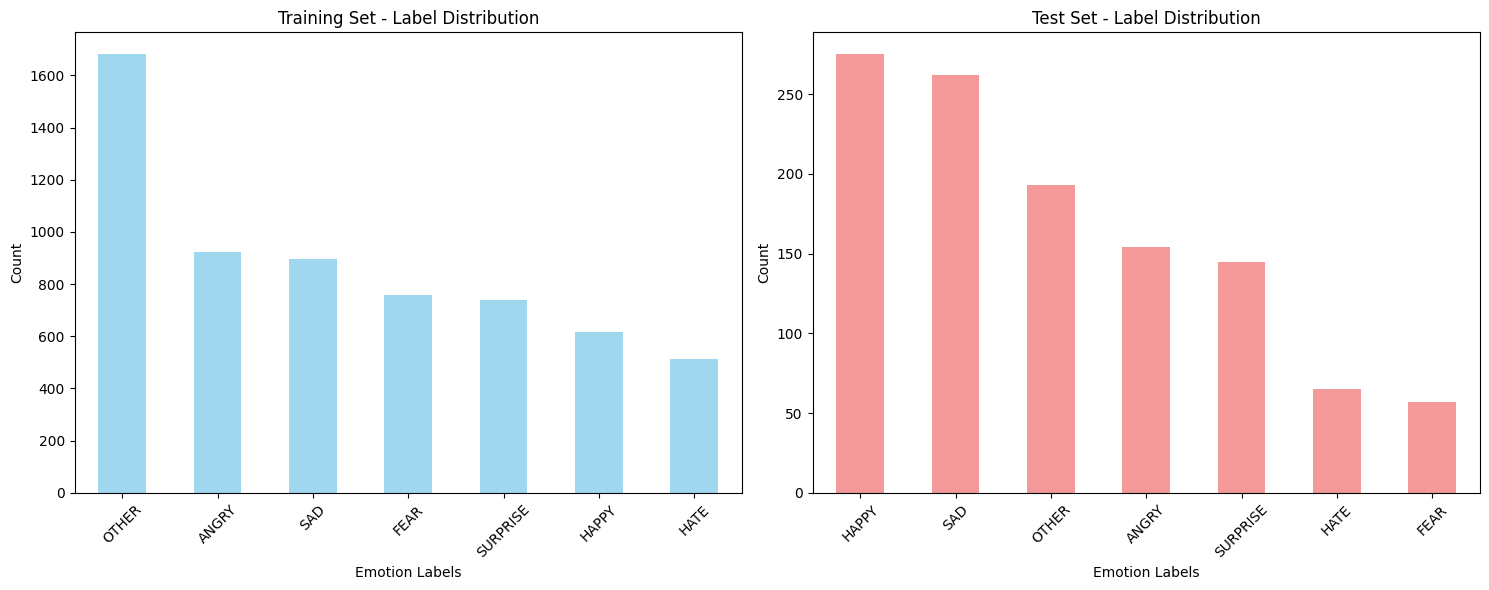

In [5]:
print("\nLabel Distribution Analysis:")

# Training set label distribution
train_label_counts = train_df['label'].value_counts()
print("Training set labels:")
for label, count in train_label_counts.items():
    percentage = (count / len(train_df)) * 100
    print(f"  {label}: {count} ({percentage:.1f}%)")

# Test set label distribution
test_label_counts = test_df['label'].value_counts()
print("\nTest set labels:")
for label, count in test_label_counts.items():
    percentage = (count / len(test_df)) * 100
    print(f"  {label}: {count} ({percentage:.1f}%)")

# Visualize label distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

train_label_counts.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)
ax1.set_title('Training Set - Label Distribution')
ax1.set_xlabel('Emotion Labels')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

test_label_counts.plot(kind='bar', ax=ax2, color='lightcoral', alpha=0.8)
ax2.set_title('Test Set - Label Distribution')
ax2.set_xlabel('Emotion Labels')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ----------------------------
# Text Length Analysis
# ----------------------------


Text Length Analysis:
Text length statistics (characters):
Train - Mean: 114.0, Median: 90.0
Test - Mean: 159.7, Median: 153.0

Word count statistics:
Train - Mean: 22.4, Median: 18.0
Test - Mean: 31.1, Median: 30.0


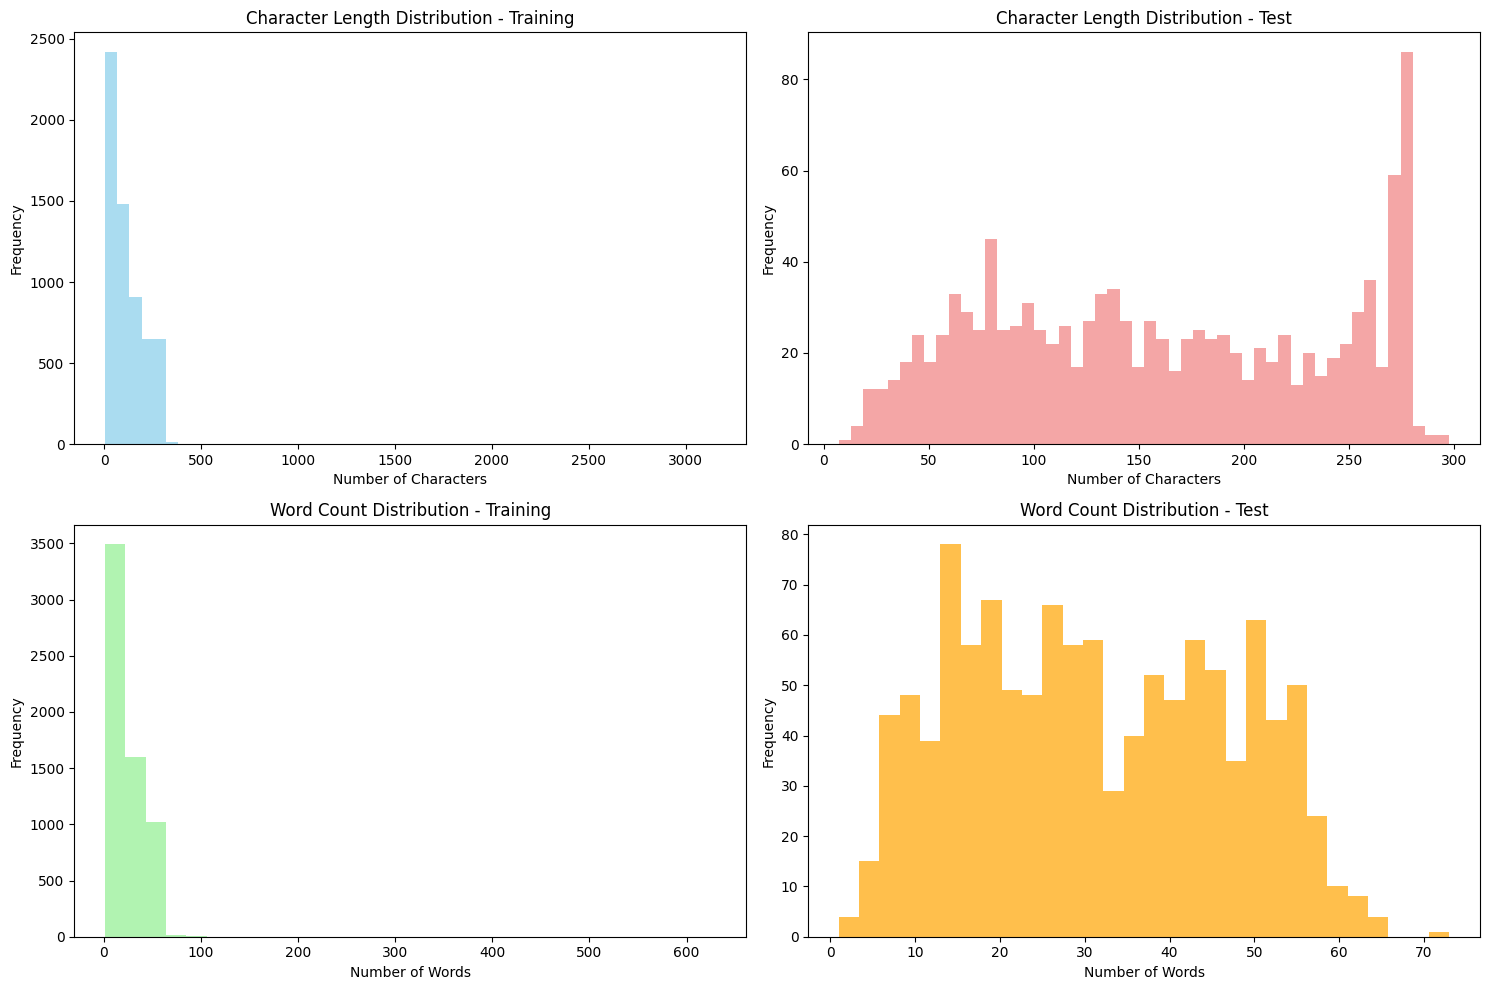

In [6]:
print("\nText Length Analysis:")

# Calculate text lengths
train_df['text_length'] = train_df['text'].str.len()
test_df['text_length'] = test_df['text'].str.len()

# Calculate word counts
train_df['word_count'] = train_df['text'].str.split().str.len()
test_df['word_count'] = test_df['text'].str.split().str.len()

# Statistics
print("Text length statistics (characters):")
print(f"Train - Mean: {train_df['text_length'].mean():.1f}, Median: {train_df['text_length'].median():.1f}")
print(f"Test - Mean: {test_df['text_length'].mean():.1f}, Median: {test_df['text_length'].median():.1f}")

print("\nWord count statistics:")
print(f"Train - Mean: {train_df['word_count'].mean():.1f}, Median: {train_df['word_count'].median():.1f}")
print(f"Test - Mean: {test_df['word_count'].mean():.1f}, Median: {test_df['word_count'].median():.1f}")

# Visualize text lengths
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Character length distributions
ax1.hist(train_df['text_length'], bins=50, alpha=0.7, color='skyblue', label='Train')
ax1.set_title('Character Length Distribution - Training')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Frequency')

ax2.hist(test_df['text_length'], bins=50, alpha=0.7, color='lightcoral', label='Test')
ax2.set_title('Character Length Distribution - Test')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Frequency')

# Word count distributions
ax3.hist(train_df['word_count'], bins=30, alpha=0.7, color='lightgreen', label='Train')
ax3.set_title('Word Count Distribution - Training')
ax3.set_xlabel('Number of Words')
ax3.set_ylabel('Frequency')

ax4.hist(test_df['word_count'], bins=30, alpha=0.7, color='orange', label='Test')
ax4.set_title('Word Count Distribution - Test')
ax4.set_xlabel('Number of Words')
ax4.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# ----------------------------
# Enhanced Preprocessing
# ----------------------------

In [7]:
def normalize_persian(text):
    text = str(text)
    # Normalize Arabic to Persian characters
    text = text.replace('Ÿä', '€å').replace('ŸÉ', '⁄©')
    text = text.replace('ÿ°', 'ÿ¶').replace('ÿ£', 'ÿß').replace('ÿ•', 'ÿß')
    # Remove punctuation but keep Persian characters
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Enhanced Persian stopwords list
stopwords = set([
    'ÿßÿ≤', 'ÿ®ÿß', 'ÿ®ÿ±ÿß€å', 'ÿ®Ÿá', 'ÿØÿ±', 'ÿ±ÿß', 'Ÿà', '⁄©Ÿá', 'ÿß€åŸÜ', 'ÿ¢ŸÜ', '€å⁄©', 'Ÿáÿ±',
    'ŸÖŸÜ', 'ÿ™Ÿà', 'ÿßŸà', 'ŸÖÿß', 'ÿ¥ŸÖÿß', 'ÿ¢ŸÜŸáÿß', 'ÿÆŸàÿØ', 'ÿÆŸàÿØŸÖ', 'ÿÆŸàÿØÿ™', 'ÿÆŸàÿØÿ¥',
    'Ÿá€å⁄Ü', 'ŸáŸÖŸá', 'ÿß€å', 'ÿß⁄Øÿ±', '⁄ÜŸàŸÜ', 'ŸàŸÑ€å', 'ÿßŸÖÿß', 'Ÿæÿ≥', 'ÿ™ÿß', 'ŸàŸÇÿ™€å',
    'ŸáŸÖ', 'Ÿáÿ≥ÿ™', 'ŸÜ€åÿ≥ÿ™', 'ÿ®ŸàÿØ', 'ÿ®ŸàÿØŸá', 'ÿ¥ÿØŸá', 'ÿ¥ÿØ', 'ŸÖ€å', 'ŸÜŸÖ€å', 'ÿÆŸàÿßŸáÿØ'
])

def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word not in stopwords and len(word) > 1])

def preprocess(text):
    text = normalize_persian(text)
    text = remove_stopwords(text)
    return text

print("\nüîß Preprocessing texts...")

# Store original texts for reference
train_df['original_text'] = train_df['text'].copy()
test_df['original_text'] = test_df['text'].copy()

# Preprocess texts
train_df['text'] = train_df['text'].apply(preprocess)
test_df['text'] = test_df['text'].apply(preprocess)

# Show preprocessing examples
print("\nPreprocessing Examples:")
for i in range(3):
    if i < len(train_df):
        print(f"Original: {train_df['original_text'].iloc[i][:100]}...")
        print(f"Processed: {train_df['text'].iloc[i][:100]}...")
        print(f"Label: {train_df['label'].iloc[i]}")
        print("-" * 50)


üîß Preprocessing texts...

Preprocessing Examples:
Original: ÿÆ€åŸÑ€å ⁄©Ÿà⁄Ü€å⁄© Ÿáÿ≥ÿ™ŸÜ Ÿà ÿ≥ÿß€åÿ≤ÿ¥ŸàŸÜ ÿ®ÿØÿ±ÿØ ŸÜŸÖ€åÿÆŸàÿ±Ÿá ŸÖ€åÿÆŸàÿßŸÖ Ÿæÿ≥ ÿ®ÿØŸÖ...
Processed: ÿÆ€åŸÑ€å ⁄©Ÿà⁄Ü€å⁄© Ÿáÿ≥ÿ™ŸÜ ÿ≥ÿß€åÿ≤ÿ¥ŸàŸÜ ÿ®ÿØÿ±ÿØ ŸÜŸÖ€åÿÆŸàÿ±Ÿá ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸÖ...
Label: SAD
--------------------------------------------------
Original: ÿßÿ≤ ÿµÿØÿß€å Ÿæÿ±ŸÜÿØŸá ÿØŸÖ ÿØŸÖÿß€å ÿµÿ®ÿ≠ ŸÖÿ™ŸÜŸÅÿ±ŸÖ ŸÖÿ™ŸÜŸÅÿ±ŸÖ ŸÖÿ™ŸÜŸÅÿ±ŸÖ...
Processed: ÿµÿØÿß€å Ÿæÿ±ŸÜÿØŸá ÿØŸÖ ÿØŸÖÿß€å ÿµÿ®ÿ≠ ŸÖÿ™ŸÜŸÅÿ±ŸÖ ŸÖÿ™ŸÜŸÅÿ±ŸÖ ŸÖÿ™ŸÜŸÅÿ±ŸÖ...
Label: HATE
--------------------------------------------------
Original:  "⁄©€åŸÅ€åÿ™ÿ¥ ÿÆ€åŸÑ€å ÿÆŸàÿ®Ÿá ÿ®ÿß ÿ¥⁄© ÿÆÿ±€åÿØŸÖ ŸàŸÑ€å ŸàÿßŸÇÿπÿß ÿ±ÿßÿ∂€åŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿ≠ÿØŸàÿØ 2 ŸÖÿßŸá ÿßÿ≥ÿ™ŸÅÿßÿØŸá¬´ŸÖÿ™ÿ£ÿ≥ŸÅÿßŸÜŸá ÿ®ÿßÿÆÿ®ÿ± ÿ¥ÿØ€åŸÖ¬ª ⁄©Ÿá ŸÅÿ±ÿØ...
Processed: ⁄©€åŸÅ€åÿ™ÿ¥ ÿÆ€åŸÑ€å ÿÆŸàÿ®Ÿá ÿ¥⁄© ÿÆÿ±€åÿØŸÖ ŸàÿßŸÇÿπÿß ÿ±ÿßÿ∂€åŸÖ ÿ®ÿπÿØ ÿ≠ÿØŸàÿØ ŸÖÿßŸá ÿßÿ≥ÿ™ŸÅÿßÿØŸáŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿ®ÿßÿÆÿ®ÿ± ÿ¥ÿØ€åŸÖ ŸÅÿ±ÿØ€å ÿß€åÿ±ÿßŸÜÿ¥Ÿáÿ± ÿ≠ÿØÿßŸÇŸÑ ÿØÿÆ...
Label: SAD
---------------

# ----------------------------
# Enhanced Vectorization
# ----------------------------

In [8]:
print("\nCreating TF-IDF features...")

# Try different vectorizer configurations
vectorizers = {
    'unigrams': TfidfVectorizer(ngram_range=(1, 1), max_features=3000, min_df=2),
    'bigrams': TfidfVectorizer(ngram_range=(1, 2), max_features=5000, min_df=2),
    'trigrams': TfidfVectorizer(ngram_range=(1, 3), max_features=7000, min_df=2)
}

results = {}

for name, vectorizer in vectorizers.items():
    print(f"\nTesting {name} configuration...")

    # Fit and transform
    X_train = vectorizer.fit_transform(train_df['text'])
    X_test = vectorizer.transform(test_df['text'])

    y_train = train_df['label']
    y_test = test_df['label']

    # Train model
    clf = LogisticRegression(max_iter=500, random_state=42)
    clf.fit(X_train, y_train)

    # Cross validation
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

    # Test predictions
    y_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': test_accuracy,
        'vectorizer': vectorizer,
        'model': clf,
        'predictions': y_pred
    }

    print(f"CV Accuracy: {cv_scores.mean():.4f} (¬±{cv_scores.std():.4f})")
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Select best configuration
best_config = max(results.keys(), key=lambda k: results[k]['test_accuracy'])
print(f"\nBest configuration: {best_config}")
print(f"Best test accuracy: {results[best_config]['test_accuracy']:.4f}")

# Use best configuration for detailed analysis
vectorizer = results[best_config]['vectorizer']
clf = results[best_config]['model']
y_pred = results[best_config]['predictions']


Creating TF-IDF features...

Testing unigrams configuration...
CV Accuracy: 0.5587 (¬±0.0383)
Test Accuracy: 0.4023

Testing bigrams configuration...
CV Accuracy: 0.5576 (¬±0.0400)
Test Accuracy: 0.4031

Testing trigrams configuration...
CV Accuracy: 0.5553 (¬±0.0377)
Test Accuracy: 0.4005

Best configuration: bigrams
Best test accuracy: 0.4031


# ----------------------------
# Detailed Model Evaluation
# ----------------------------


Detailed Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

       ANGRY       0.51      0.34      0.41       154
        FEAR       0.74      0.54      0.63        57
       HAPPY       0.65      0.18      0.28       275
        HATE       0.39      0.11      0.17        65
       OTHER       0.25      0.86      0.39       193
         SAD       0.63      0.50      0.55       262
    SURPRISE       0.66      0.20      0.31       145

    accuracy                           0.40      1151
   macro avg       0.55      0.39      0.39      1151
weighted avg       0.55      0.40      0.39      1151



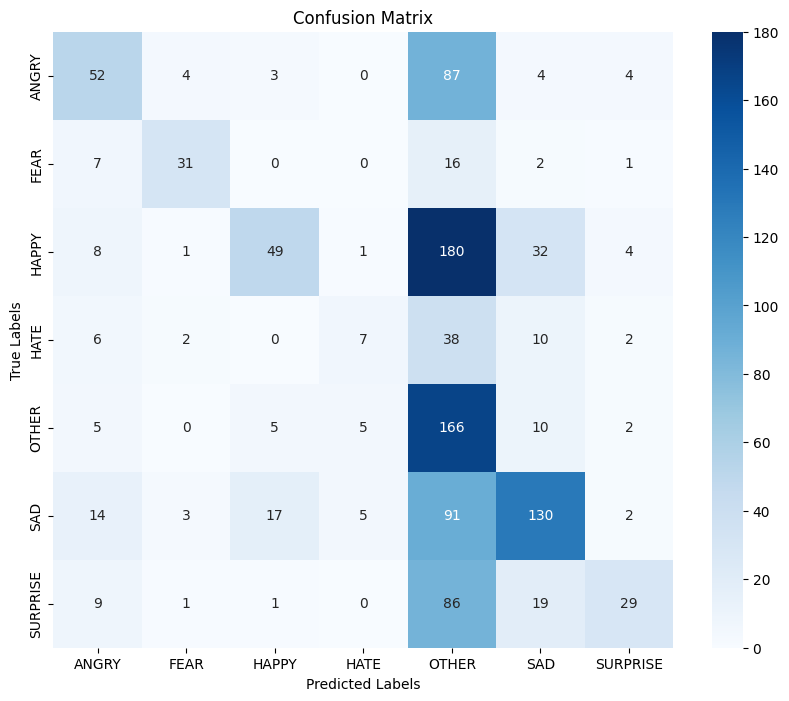


Per-class Accuracy:
  ANGRY: 0.338
  FEAR: 0.544
  HAPPY: 0.178
  HATE: 0.108
  OTHER: 0.860
  SAD: 0.496
  SURPRISE: 0.200


In [9]:
print("\nDetailed Model Evaluation:")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for label, acc in zip(labels, per_class_accuracy):
    print(f"  {label}: {acc:.3f}")

# ----------------------------
# Feature Analysis
# ----------------------------

In [10]:
print("\nMost Important Features per Class:")

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get top features for each class
n_top_features = 10
for i, class_label in enumerate(clf.classes_):
    top_features_idx = clf.coef_[i].argsort()[-n_top_features:][::-1]
    top_features = [feature_names[idx] for idx in top_features_idx]
    top_weights = [clf.coef_[i][idx] for idx in top_features_idx]

    print(f"\nTop features for '{class_label}':")
    for feature, weight in zip(top_features, top_weights):
        print(f"  {feature}: {weight:.3f}")


Most Important Features per Class:

Top features for 'ANGRY':
  ÿßÿπÿµÿßÿ®ŸÖ: 8.679
  ÿÆÿ¥ŸÖ: 4.256
  ÿπÿµÿ®€åŸÖ: 3.524
  ÿ®€å: 2.653
  ÿÆŸàÿ±ÿØ: 2.381
  ⁄©ŸàŸÅÿ™: 2.019
  ÿπÿµÿ®ÿßŸÜ€å: 1.937
  ÿπŸÇÿØŸá: 1.867
  ŸÖÿ±ÿØŸÖ: 1.841
  ÿÆÿ±: 1.753

Top features for 'FEAR':
  ŸÖ€åÿ™ÿ±ÿ≥ŸÖ: 8.537
  ÿ™ÿ±ÿ≥: 7.545
  ÿ™ÿ±ÿ≥ŸÜÿß⁄©: 5.119
  ÿ™ÿ±ÿ≥ŸÜÿß⁄©Ÿá: 4.760
  ÿ™ÿ±ÿ≥€åÿØŸÖ: 4.164
  Ÿàÿ≠ÿ¥ÿ™ŸÜÿß⁄©: 3.871
  Ÿàÿ≠ÿ¥ÿ™ŸÜÿß⁄©Ÿá: 3.749
  Ÿàÿ≠ÿ¥ÿ™: 3.530
  ÿ™ÿ±ÿ≥ŸÖ: 3.114
  ÿ™ÿ±ÿ≥ŸÜÿß⁄©€å: 1.977

Top features for 'HAPPY':
  ÿ¥ÿßÿØ: 3.839
  ÿÆŸÜÿØŸá: 3.303
  ÿ¥ÿßÿØ€å: 3.011
  ÿπÿßŸÑ€å: 2.984
  ŸÖÿ±ÿ≥€å: 2.497
  ŸÖÿ®ÿßÿ±⁄©: 2.497
  ŸÖŸÖŸÜŸàŸÜŸÖ: 2.478
  ÿÆŸàÿ®€å: 2.193
  ŸÑÿ∞ÿ™: 2.186
  ÿÆŸàÿ®: 2.175

Top features for 'HATE':
  ŸÖÿ™ŸÜŸÅÿ±ŸÖ: 9.646
  ŸÖÿ™ŸÜŸÅÿ±: 6.268
  ÿ®ÿØŸÖ ŸÖ€åÿßÿØ: 6.123
  ŸÑÿπŸÜÿ™: 3.954
  ŸÖ€åÿßÿØ: 3.827
  ÿ®€åÿ≤ÿßÿ±ŸÖ: 3.810
  ÿ®ÿØŸÖ: 3.726
  ŸÜŸÅÿ±ÿ™: 2.709
  ŸÖŸÜÿ≤ÿ¨ÿ±: 1.880
  ŸÖ€åŸàŸÖÿØ: 1.559

Top features for 'OTHER':
  ŸÖÿ≥ÿ¶ŸàŸÑÿßŸÜ: 2.892
  ÿßÿπÿ™ÿ±ÿßÿ∂: 2.570
  ŸÖŸàŸÅŸÇ

# ----------------------------
# Error Analysis
# ----------------------------

In [11]:
print("\nError Analysis:")

# Find misclassified examples
test_df_copy = test_df.copy()
test_df_copy['predicted'] = y_pred
test_df_copy['correct'] = test_df_copy['label'] == test_df_copy['predicted']

misclassified = test_df_copy[~test_df_copy['correct']]

print(f"Total misclassified samples: {len(misclassified)}")
print(f"Error rate: {len(misclassified) / len(test_df_copy):.1%}")

# Show common misclassification patterns
error_patterns = misclassified.groupby(['label', 'predicted']).size().sort_values(ascending=False)
print("\nMost common misclassification patterns:")
for (true_label, pred_label), count in error_patterns.head(10).items():
    print(f"  {true_label} ‚Üí {pred_label}: {count} cases")

# Show some misclassified examples
print("\nSample misclassified texts:")
for i, row in misclassified.head(5).iterrows():
    print(f"Text: {row['original_text'][:100]}...")
    print(f"True: {row['label']} | Predicted: {row['predicted']}")
    print("-" * 50)


Error Analysis:
Total misclassified samples: 687
Error rate: 59.7%

Most common misclassification patterns:
  HAPPY ‚Üí OTHER: 180 cases
  SAD ‚Üí OTHER: 91 cases
  ANGRY ‚Üí OTHER: 87 cases
  SURPRISE ‚Üí OTHER: 86 cases
  HATE ‚Üí OTHER: 38 cases
  HAPPY ‚Üí SAD: 32 cases
  SURPRISE ‚Üí SAD: 19 cases
  SAD ‚Üí HAPPY: 17 cases
  FEAR ‚Üí OTHER: 16 cases
  SAD ‚Üí ANGRY: 14 cases

Sample misclassified texts:
Text: ÿßŸäŸÜ ÿ¥ÿßŸäÿØ ÿßŸàŸÑŸäŸÜ ÿπÿ≤ÿßŸâ ÿπŸÖŸàŸÖŸâ ŸàÿßŸÇÿπŸâ ÿßÿ≥ÿ™ ŸÉŸá ŸäÿßÿØ ÿØÿßÿ±ŸÖ. ÿ™ŸÖÿßŸÖ Ÿàÿ¨ŸàÿØŸÖ ÿπÿ≤ÿßÿØÿßÿ± ÿßÿ≥ÿ™ÿõ Ÿæÿ± ÿßÿ≤ ⁄Øÿ±ŸäŸáÿå Ÿæÿ± ÿßÿ≤ ÿÆÿ¥ŸÖÿå Ÿæÿ± ÿßÿ≤...
True: SAD | Predicted: OTHER
--------------------------------------------------
Text: ÿØ€åÿ¥ÿ® ÿ®ÿπÿØ ÿßÿ≤ ÿßÿ±ÿ≥ÿßŸÑ ÿ™Ÿà€åÿ™ ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿ¢ÿ´ÿßÿ± ÿ®ÿßÿ≥ÿ™ÿßŸÜ€å ÿ™Ÿà€åÿ™ ÿØ€å⁄Øÿ±€å ŸÜŸàÿ¥ÿ™ŸÖ ŸàŸÑ€å Ÿáÿ±⁄ÜŸá ŸÖŸÜÿ™ÿ∏ÿ± ÿ¥ÿØŸÖ ÿßÿ±ÿ≥ÿßŸÑ ŸÜÿ¥ÿØÿå ÿßÿ≤ ŸáŸÖŸàŸÜ ...
True: HAPPY | Predicted: SAD
--------------------------------------------------
Text: ÿßŸÖÿ¥ÿ® ⁄ØŸÅÿ™ ŸÜÿßŸÖÿ≤ÿØ€å ÿØŸàÿ≥ÿ™ÿ¥ ⁄©Ÿ

# ----------------------------
# Model Comparison Summary
# ----------------------------


Model Configuration Comparison:
Configuration  CV_Accuracy  CV_Std  Test_Accuracy
     unigrams       0.5587  0.0383         0.4023
      bigrams       0.5576  0.0400         0.4031
     trigrams       0.5553  0.0377         0.4005


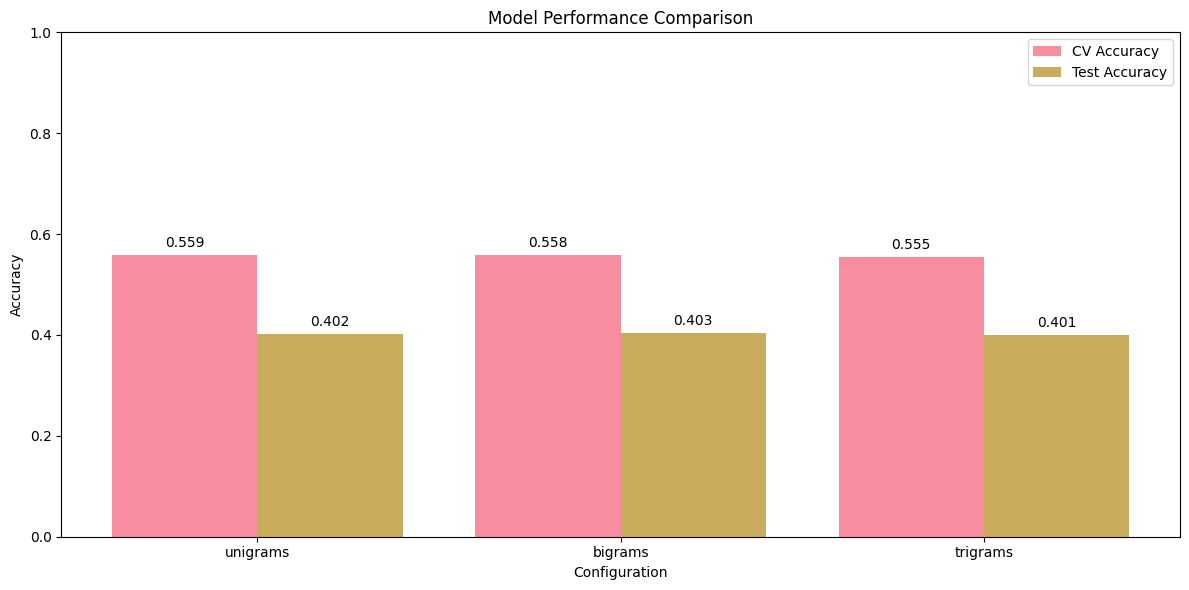

In [12]:
print("\nModel Configuration Comparison:")
comparison_df = pd.DataFrame({
    'Configuration': list(results.keys()),
    'CV_Accuracy': [results[k]['cv_mean'] for k in results.keys()],
    'CV_Std': [results[k]['cv_std'] for k in results.keys()],
    'Test_Accuracy': [results[k]['test_accuracy'] for k in results.keys()]
})

print(comparison_df.to_string(index=False, float_format='%.4f'))

# Visualize comparison
plt.figure(figsize=(12, 6))
x = range(len(comparison_df))
plt.bar([i-0.2 for i in x], comparison_df['CV_Accuracy'],
        width=0.4, label='CV Accuracy', alpha=0.8)
plt.bar([i+0.2 for i in x], comparison_df['Test_Accuracy'],
        width=0.4, label='Test Accuracy', alpha=0.8)
plt.xlabel('Configuration')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(x, comparison_df['Configuration'])
plt.legend()
plt.ylim(0, 1)
for i, (cv, test) in enumerate(zip(comparison_df['CV_Accuracy'], comparison_df['Test_Accuracy'])):
    plt.text(i-0.2, cv+0.01, f'{cv:.3f}', ha='center', va='bottom')
    plt.text(i+0.2, test+0.01, f'{test:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# ----------------------------
# Prediction Function
# ----------------------------

In [13]:
def predict_emotion(text, vectorizer=vectorizer, model=clf):
    """
    Predict emotion for a given Persian text
    """
    processed_text = preprocess(text)
    vectorized_text = vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)[0]
    probabilities = model.predict_proba(vectorized_text)[0]

    # Get probability for each class
    prob_dict = dict(zip(model.classes_, probabilities))

    return {
        'prediction': prediction,
        'confidence': max(probabilities),
        'all_probabilities': prob_dict,
        'processed_text': processed_text
    }

# Test the prediction function
print("\nüîÆ Testing Prediction Function:")
sample_texts = [
    "ÿßŸÖÿ±Ÿàÿ≤ ÿ±Ÿàÿ≤ ÿ®ÿ≥€åÿßÿ± ÿÆŸàÿ®€å ÿ®ŸàÿØ Ÿà ÿÆ€åŸÑ€å ÿÆŸàÿ¥ÿ≠ÿßŸÑŸÖ",
    "ŸÖŸÜ ÿÆ€åŸÑ€å ŸÜÿßÿ±ÿßÿ≠ÿ™ Ÿà ÿ∫ŸÖ⁄Ø€åŸÜŸÖ",
    "ÿ±Ÿàÿ≠ÿ¥ ÿ¥ÿßÿØ Ÿà €åÿßÿØÿ¥ ⁄Øÿ±ÿßŸÖ€å"
]

for text in sample_texts:
    result = predict_emotion(text)
    print(f"\nText: {text}")
    print(f"Predicted emotion: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.3f}")
    print("All probabilities:")
    for emotion, prob in sorted(result['all_probabilities'].items(),
                              key=lambda x: x[1], reverse=True):
        print(f"  {emotion}: {prob:.3f}")

print("\nAnalysis Complete!")
print("Key Insights:")
print(f"- Best model configuration: {best_config}")
print(f"- Test accuracy: {results[best_config]['test_accuracy']:.1%}")
print(f"- Total features: {len(feature_names)}")
print("- Enhanced preprocessing with stopword removal")
print("- Comprehensive error analysis completed")
print("- Ready-to-use prediction function available")


üîÆ Testing Prediction Function:

Text: ÿßŸÖÿ±Ÿàÿ≤ ÿ±Ÿàÿ≤ ÿ®ÿ≥€åÿßÿ± ÿÆŸàÿ®€å ÿ®ŸàÿØ Ÿà ÿÆ€åŸÑ€å ÿÆŸàÿ¥ÿ≠ÿßŸÑŸÖ
Predicted emotion: HAPPY
Confidence: 0.628
All probabilities:
  HAPPY: 0.628
  SAD: 0.157
  OTHER: 0.053
  FEAR: 0.050
  ANGRY: 0.038
  SURPRISE: 0.038
  HATE: 0.036

Text: ŸÖŸÜ ÿÆ€åŸÑ€å ŸÜÿßÿ±ÿßÿ≠ÿ™ Ÿà ÿ∫ŸÖ⁄Ø€åŸÜŸÖ
Predicted emotion: SAD
Confidence: 0.734
All probabilities:
  SAD: 0.734
  ANGRY: 0.062
  HAPPY: 0.061
  OTHER: 0.054
  FEAR: 0.038
  SURPRISE: 0.030
  HATE: 0.022

Text: ÿ±Ÿàÿ≠ÿ¥ ÿ¥ÿßÿØ Ÿà €åÿßÿØÿ¥ ⁄Øÿ±ÿßŸÖ€å
Predicted emotion: SAD
Confidence: 0.822
All probabilities:
  SAD: 0.822
  HAPPY: 0.052
  OTHER: 0.044
  ANGRY: 0.029
  SURPRISE: 0.020
  FEAR: 0.020
  HATE: 0.013

Analysis Complete!
Key Insights:
- Best model configuration: bigrams
- Test accuracy: 40.3%
- Total features: 5000
- Enhanced preprocessing with stopword removal
- Comprehensive error analysis completed
- Ready-to-use prediction function available


In [14]:
!pip install gensim

In [15]:
import re, os, json, random, numpy as np, pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPool1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from gensim.models import Word2Vec

# reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# ÿØÿßÿØŸá‚ÄåŸáÿß
import pandas as pd
df_train = pd.read_csv(r"/content/arman-text-emotion/dataset/train.tsv",
                       sep='\t', header=None, names=['text','emotion'], encoding='utf-8')
df_test  = pd.read_csv(r"/content/arman-text-emotion/dataset/test.tsv",
                       sep='\t', header=None, names=['text','emotion'], encoding='utf-8')

print(df_train.head(3))
print(df_train['emotion'].value_counts())

                                                text emotion
0  ÿÆ€åŸÑ€å ⁄©Ÿà⁄Ü€å⁄© Ÿáÿ≥ÿ™ŸÜ Ÿà ÿ≥ÿß€åÿ≤ÿ¥ŸàŸÜ ÿ®ÿØÿ±ÿØ ŸÜŸÖ€åÿÆŸàÿ±Ÿá ŸÖ€åÿÆŸàÿßŸÖ ...     SAD
1     ÿßÿ≤ ÿµÿØÿß€å Ÿæÿ±ŸÜÿØŸá ÿØŸÖ ÿØŸÖÿß€å ÿµÿ®ÿ≠ ŸÖÿ™ŸÜŸÅÿ±ŸÖ ŸÖÿ™ŸÜŸÅÿ±ŸÖ ŸÖÿ™ŸÜŸÅÿ±ŸÖ    HATE
2   "⁄©€åŸÅ€åÿ™ÿ¥ ÿÆ€åŸÑ€å ÿÆŸàÿ®Ÿá ÿ®ÿß ÿ¥⁄© ÿÆÿ±€åÿØŸÖ ŸàŸÑ€å ŸàÿßŸÇÿπÿß ÿ±ÿßÿ∂€åŸÖ...     SAD
emotion
OTHER       1681
ANGRY        923
SAD          896
FEAR         757
SURPRISE     739
HAPPY        618
HATE         511
Name: count, dtype: int64


In [17]:
import re

# ÿ≠ÿ∞ŸÅ ÿ≠ÿ±⁄©ÿßÿ™ ÿπÿ±ÿ®€åÿå ŸÜ€åŸÖ‚ÄåŸÅÿßÿµŸÑŸá Ÿà ...
DIACRITICS = re.compile(r'[\u064B-\u065F\u0670\u200c\u200f]')

def normalize_persian(text: str) -> str:
    if not isinstance(text, str): return ""
    text = text.strip()
    # ŸÜÿ±ŸÖÿßŸÑ‚Äåÿ≥ÿßÿ≤€å ÿ≠ÿ±ŸàŸÅ
    text = (text
            .replace('Ÿä','€å').replace('ŸÉ','⁄©')
            .replace('€Ä','Ÿá').replace('ÿ©','Ÿá')
            .replace('ÿ§','Ÿà').replace('ÿ•','ÿß').replace('ÿ£','ÿß').replace('ÿ¢','ÿß'))
    # ÿ≠ÿ∞ŸÅ ÿßÿπÿ±ÿßÿ®
    text = DIACRITICS.sub(' ', text)
    # ÿ≠ÿ∞ŸÅ ŸÅÿßÿµŸÑŸá‚ÄåŸáÿß€å ÿßÿ∂ÿßŸÅ€å
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# ÿßŸÑ⁄ØŸà€å ÿ≥ÿßÿØŸá ÿ®ÿ±ÿß€å ⁄©ŸÑŸÖÿßÿ™ ŸÅÿßÿ±ÿ≥€å/ÿßŸÜ⁄ØŸÑ€åÿ≥€å/ÿπÿØÿØ
TOKEN_PATTERN = re.compile(r"[A-Za-z\u0600-\u06FF]+|\d+")

def tokenize_fa(text: str):
    text = normalize_persian(text)
    toks = TOKEN_PATTERN.findall(text)
    toks = [t.lower() for t in toks if len(t) > 0]
    return toks

# ÿßÿπŸÖÿßŸÑ ÿ±Ÿà€å ÿØÿßÿØŸá‚ÄåŸáÿß
df_train["tokens"] = df_train["text"].apply(tokenize_fa)
df_test["tokens"]  = df_test["text"].apply(tokenize_fa)

In [18]:
# ŸÅŸÇÿ∑ ÿ¨ŸÖŸÑÿßÿ™ ÿ∫€åÿ±ÿÆÿßŸÑ€å
sentences = [t for t in df_train["tokens"].tolist() if len(t) > 0]

EMB_DIM = 300
w2v = Word2Vec(
    sentences=sentences,
    vector_size=EMB_DIM, window=5, min_count=2,
    workers=4, sg=1, negative=10, epochs=15, seed=SEED
)

print("Vocab size (gensim):", len(w2v.wv))

Vocab size (gensim): 8763


In [19]:
# ŸÅŸÇÿ∑ ÿ±Ÿà€å train ŸÅ€åÿ™ ŸÖ€å‚Äå⁄©ŸÜ€åŸÖ
train_texts = [" ".join(t) for t in df_train["tokens"]]
test_texts  = [" ".join(t) for t in df_test["tokens"]]

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Tokenizer vocab_size:", vocab_size)

X_train = tokenizer.texts_to_sequences(train_texts)
X_test  = tokenizer.texts_to_sequences(test_texts)
# ÿ∑ŸàŸÑ ÿ¨ŸÖŸÑÿßÿ™ ÿØÿ± train Ÿà test
train_lengths = df_train["tokens"].apply(len)
test_lengths  = df_test["tokens"].apply(len)

# ŸÖÿ´ŸÑÿß 95 ÿØÿ±ÿµÿØ ÿ¨ŸÖŸÑÿßÿ™ ÿ≤€åÿ± ÿß€åŸÜ ÿ∑ŸàŸÑ Ÿáÿ≥ÿ™ŸÜÿØ
maxlen = int(np.percentile(pd.concat([train_lengths, test_lengths]), 95))

# ŸÖÿ≠ÿØŸàÿØ€åÿ™ ŸÖÿπŸÇŸàŸÑ ÿ®ÿ∞ÿßÿ±€åŸÖ (ŸÜŸá ÿÆ€åŸÑ€å ÿ®ÿ≤ÿ±⁄Øÿå ŸÜŸá ÿÆ€åŸÑ€å ⁄©Ÿà⁄Ü⁄©)
maxlen = max(8, min(maxlen, 80))

print("Chosen maxlen:", maxlen)

X_train = pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
X_test  = pad_sequences(X_test,  maxlen=maxlen, padding='post', truncating='post')

# ŸÑ€åÿ®ŸÑ‚ÄåŸáÿß
le = LabelEncoder()
y_train = le.fit_transform(df_train["emotion"])
y_test  = le.transform(df_test["emotion"])  # ŸÅÿ±ÿ∂: ⁄©ŸÑÿßÿ≥‚ÄåŸáÿß ÿØÿ± test ÿ≤€åÿ±ŸÖÿ¨ŸÖŸàÿπŸá‚Äå€å train Ÿáÿ≥ÿ™ŸÜÿØ
num_classes = len(le.classes_)
print("Classes:", dict(zip(le.classes_, range(num_classes))))

# ŸÖÿßÿ™ÿ±€åÿ≥ ÿßŸÖÿ®ÿØ€åŸÜ⁄Ø ÿßÿ≤ Word2Vec
embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, EMB_DIM)).astype(np.float32)
hits = 0
for word, idx in word_index.items():
    if word in w2v.wv:
        embedding_matrix[idx] = w2v.wv[word]
        hits += 1
print(f"Coverage from w2v: {hits}/{vocab_size} ({hits/vocab_size:.2%})")

Tokenizer vocab_size: 23059
Chosen maxlen: 55
Classes: {'ANGRY': 0, 'FEAR': 1, 'HAPPY': 2, 'HATE': 3, 'OTHER': 4, 'SAD': 5, 'SURPRISE': 6}
Coverage from w2v: 8763/23059 (38.00%)


In [20]:
from tensorflow.keras.regularizers import l2
tf.keras.backend.clear_session()

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=EMB_DIM, input_length=maxlen,
              weights=[embedding_matrix], trainable=True),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-4))),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max', restore_best_weights=True),
    ModelCheckpoint("best_emotion_bilstm.keras", monitor='val_accuracy', save_best_only=True, mode='max')
]

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50, batch_size=64,
    callbacks=callbacks, verbose=1
)

Epoch 1/50
87/87 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 35s 305ms/step - accuracy: 0.2226 - loss: 1.9751 - val_accuracy: 0.2577 - val_loss: 1.9361
Epoch 2/50
87/87 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 28s 172ms/step - accuracy: 0.2949 - loss: 1.8174 - val_accuracy: 0.3524 - val_loss: 1.7627
Epoch 3/50
87/87 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 188ms/step - accuracy: 0.3986 - loss: 1.6308 - val_accuracy: 0.5008 - val_loss: 1.4780
Epoch 4/50
87/87 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 172ms/step - accuracy: 0.5524 - loss: 1.3216 - val_accuracy: 0.5432 - val_loss: 1.3842
Epoch 5/50
87/87 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 170ms/step - accuracy: 0.6865 - loss: 0.9802 - val_accuracy: 0.5595 - val_loss: 1.4007
Epoch 6/50
87/87 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 163ms/step - accuracy: 0.7749 - loss: 0.7473 - val_accuracy: 0.5726 - val

Test Accuracy: 0.3814
              precision    recall  f1-score   support

       ANGRY       0.58      0.20      0.30       154
        FEAR       0.53      0.51      0.52        57
       HAPPY       0.42      0.25      0.31       275
        HATE       0.36      0.08      0.13        65
       OTHER       0.34      0.60      0.43       193
         SAD       0.35      0.64      0.45       262
    SURPRISE       0.68      0.14      0.24       145

    accuracy                           0.38      1151
   macro avg       0.46      0.35      0.34      1151
weighted avg       0.44      0.38      0.35      1151



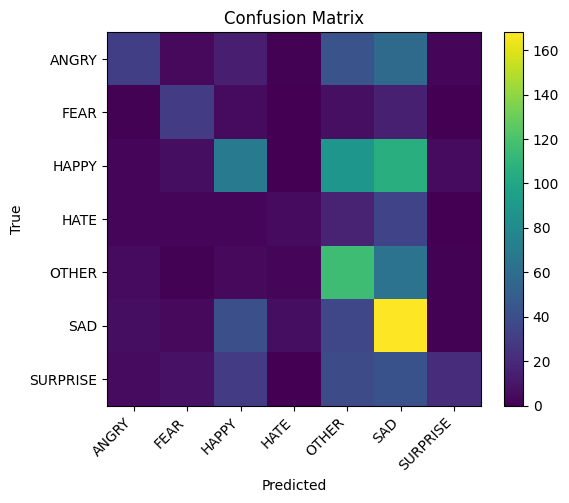

In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

y_prob = model.predict(X_test, verbose=0)
y_pred = y_prob.argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))

# ŸÖÿßÿ™ÿ±€åÿ≥ ÿØÿ±ŸáŸÖ‚Äåÿ±€åÿÆÿ™⁄Ø€å
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, le.classes_, rotation=45, ha='right')
plt.yticks(tick_marks, le.classes_)
plt.tight_layout()
plt.show()

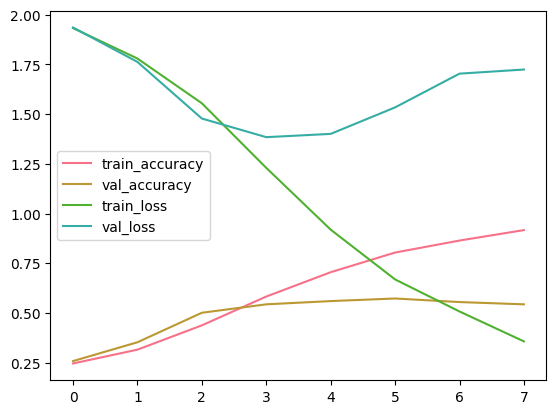

In [22]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [23]:
def prepare_texts(texts):
    toks = [" ".join(tokenize_fa(t)) for t in texts]
    seqs = tokenizer.texts_to_sequences(toks)
    return pad_sequences(seqs, maxlen=maxlen, padding='post', truncating='post')

def predict_emotion(text):
    x = prepare_texts([text])
    prob = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(prob))
    return {"emotion": le.inverse_transform([idx])[0],
            "probs": {cls: float(prob[i]) for i, cls in enumerate(le.classes_)}}

# ŸÜŸÖŸàŸÜŸá
print(predict_emotion("ÿÆ€åŸÑ€å ÿÆŸàÿ¥ÿ≠ÿßŸÑŸÖ ÿßŸÖÿ±Ÿàÿ≤ ŸÜÿ™€åÿ¨Ÿá‚Äåÿßÿ¥ ÿπÿßŸÑ€å ÿ¥ÿØ!"))
print(predict_emotion("ÿ≠ÿßŸÑŸÖ ÿ®ÿØŸá Ÿà ÿßÿ≤ ŸáŸÖŸá ⁄Ü€å ÿÆÿ≥ÿ™Ÿá‚ÄåÿßŸÖ"))


{'emotion': 'HAPPY', 'probs': {'ANGRY': 0.003196040168404579, 'FEAR': 0.0342351570725441, 'HAPPY': 0.6833015084266663, 'HATE': 0.00041358271846547723, 'OTHER': 0.13517405092716217, 'SAD': 0.04628494009375572, 'SURPRISE': 0.09739472717046738}}
{'emotion': 'OTHER', 'probs': {'ANGRY': 0.03779275342822075, 'FEAR': 0.027425481006503105, 'HAPPY': 0.15174709260463715, 'HATE': 0.05259447544813156, 'OTHER': 0.6259905099868774, 'SAD': 0.058802999556064606, 'SURPRISE': 0.04564671963453293}}


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

train_texts_joined = [" ".join(t) for t in df_train["tokens"]]
test_texts_joined  = [" ".join(t) for t in df_test["tokens"]]

# TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_texts_joined)
X_test_tfidf  = tfidf.transform(test_texts_joined)

# FastText embeddings
EMB_DIM = 100
from gensim.models import FastText
sentences = df_train['tokens'].tolist() + df_test['tokens'].tolist()
ft_model = FastText(sentences, vector_size=EMB_DIM, window=5, min_count=1, sg=1, epochs=20, seed=SEED)

def sentence_vector(tokens):
    vecs = [ft_model.wv[t] for t in tokens if t in ft_model.wv]
    if len(vecs) == 0:
        return np.zeros(EMB_DIM)
    return np.mean(vecs, axis=0)

X_train_emb = np.array([sentence_vector(t) for t in df_train['tokens']])
X_test_emb  = np.array([sentence_vector(t) for t in df_test['tokens']])

# ÿ™ÿ±⁄©€åÿ® TF-IDF Ÿà embedding
from scipy.sparse import hstack
X_train_combined = hstack([X_train_tfidf, X_train_emb])
X_test_combined  = hstack([X_test_tfidf, X_test_emb])


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

estimators = [
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED)),
    ('svc', LinearSVC(class_weight='balanced', max_iter=2000, random_state=SEED)),
    ('rf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=SEED))
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED),
    cv=5
)


              precision    recall  f1-score   support

       ANGRY       0.52      0.56      0.54       154
        FEAR       0.62      0.68      0.65        57
       HAPPY       0.59      0.41      0.48       275
        HATE       0.32      0.26      0.29        65
       OTHER       0.38      0.61      0.47       193
         SAD       0.52      0.61      0.56       262
    SURPRISE       0.60      0.29      0.39       145

    accuracy                           0.50      1151
   macro avg       0.51      0.49      0.48      1151
weighted avg       0.52      0.50      0.49      1151



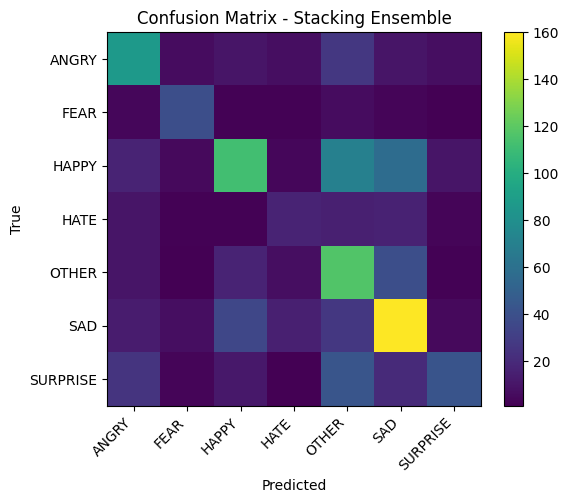

In [27]:
stack_model.fit(X_train_combined, y_train)
y_pred = stack_model.predict(X_test_combined)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ŸÖÿßÿ™ÿ±€åÿ≥ ÿØÿ±ŸáŸÖ‚Äåÿ±€åÿÆÿ™⁄Ø€å
cm = confusion_matrix(y_test, y_pred)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix - Stacking Ensemble')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45, ha='right')
plt.yticks(tick_marks, le.classes_)
plt.tight_layout()
plt.show()
